In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
from keras import optimizers

Using TensorFlow backend.


In [12]:

img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 16
intermediate_dim = 128
epsilon_std = 1.0
epochs = 100
filters = 32
num_conv = 3
batch_size = 256

In [13]:
original_img_size = (img_rows, img_cols, img_chns)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(3,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
max_1 = MaxPooling2D((2, 2), padding='same', name='maxpool1')(conv_1)

conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(max_1)
max_2 = MaxPooling2D((2, 2), padding='same', name='maxpool2')(conv_2)

conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(max_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])


# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 16 * 16, activation='relu')


output_shape = (batch_size, 16, 16, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(3,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x
vae = Model(x, x_decoded_mean_squash)

#y = CustomVariationalLayer()([x, x_decoded_mean_squash])
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

# entire model
adam = optimizers.Adam()
vae.compile(optimizer=adam)
vae.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 3)    39          input_9[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 16, 16, 3)    0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 8, 8, 32)     416         maxpool1[0][0]                   
__________________________________________________________________________________________________
maxpool2 (

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Output "conv2d_31" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_31" during training.


In [14]:

(x_train, _), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

# training
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 89s 2ms/step - loss: 675.4431 - val_loss: 647.0007
Epoch 2/100
50000/50000 [==============================] - 88s 2ms/step - loss: 640.1222 - val_loss: 636.6279
Epoch 3/100
50000/50000 [==============================] - 92s 2ms/step - loss: 634.0939 - val_loss: 634.5004
Epoch 4/100
50000/50000 [==============================] - 90s 2ms/step - loss: 631.8881 - val_loss: 632.6086
Epoch 5/100
50000/50000 [==============================] - 87s 2ms/step - loss: 630.1591 - val_loss: 629.0181
Epoch 6/100
50000/50000 [==============================] - 91s 2ms/step - loss: 626.7177 - val_loss: 626.8587
Epoch 7/100
50000/50000 [==============================] - 88s 2ms/step - loss: 625.1969 - val_loss: 625.6199
Epoch 8/100
50000/50000 [==============================] - 92s 2ms/step - loss: 624.2407 - val_loss: 625.3500
Epoch 9/100
50000/50000 [==============================] - 85s 2ms/ste

50000/50000 [==============================] - 91s 2ms/step - loss: 617.3336 - val_loss: 622.2837
Epoch 75/100
50000/50000 [==============================] - 95s 2ms/step - loss: 617.2912 - val_loss: 622.5278
Epoch 76/100
50000/50000 [==============================] - 100s 2ms/step - loss: 617.2644 - val_loss: 622.6951
Epoch 77/100
50000/50000 [==============================] - 89s 2ms/step - loss: 617.2771 - val_loss: 622.2668
Epoch 78/100
50000/50000 [==============================] - 84s 2ms/step - loss: 617.2755 - val_loss: 622.0672
Epoch 79/100
50000/50000 [==============================] - 82s 2ms/step - loss: 617.1347 - val_loss: 622.0152
Epoch 80/100
50000/50000 [==============================] - 82s 2ms/step - loss: 617.0841 - val_loss: 622.0624
Epoch 81/100
50000/50000 [==============================] - 83s 2ms/step - loss: 617.0954 - val_loss: 622.4313
Epoch 82/100
50000/50000 [==============================] - 87s 2ms/step - loss: 616.9902 - val_loss: 622.4306
Epoch 83/100


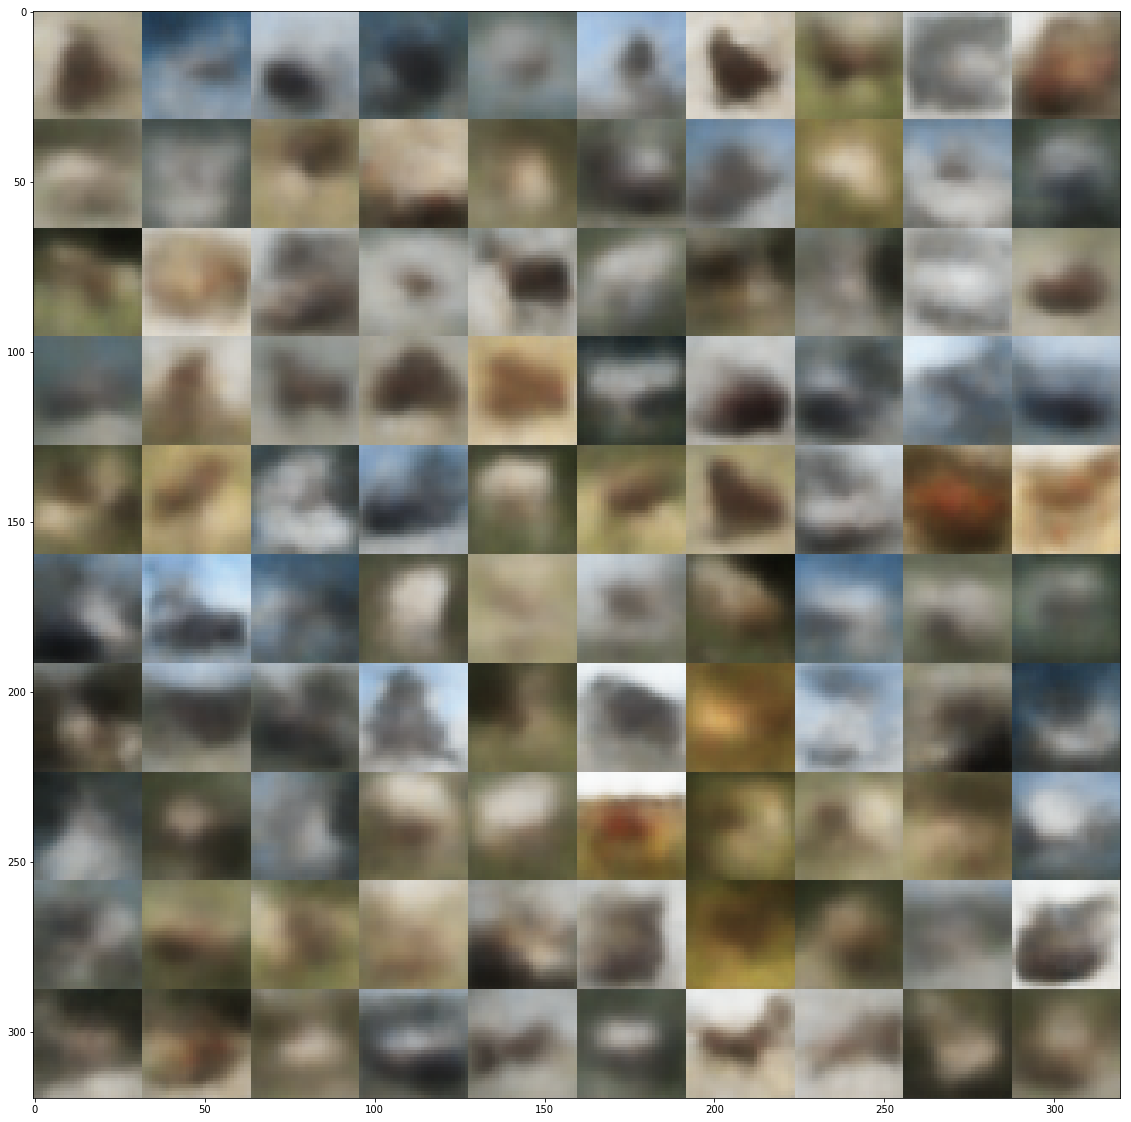

In [15]:

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(3,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# display a 2D manifold of the digits
n = 1  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_z = norm.ppf(np.linspace(0.05, 0.95, n))

#x_decoded = generator.predict([0.1,0.7,0.3], batch_size=3)
#digit = x_decoded[0].reshape(digit_size, digit_size,3)
#plt.imshow(digit,cmap='gray')
#plt.show()
#z_sample = np.array([[xi, yi, zi]])
#z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
#print("z_sample",z_sample)
#print("z_sample",z_sample.shape)

n = 10
img_size = 32
figure = np.zeros((img_size * n, img_size * n, 3))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

/Users/admin/Documents/seeg/Seegnature/torch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


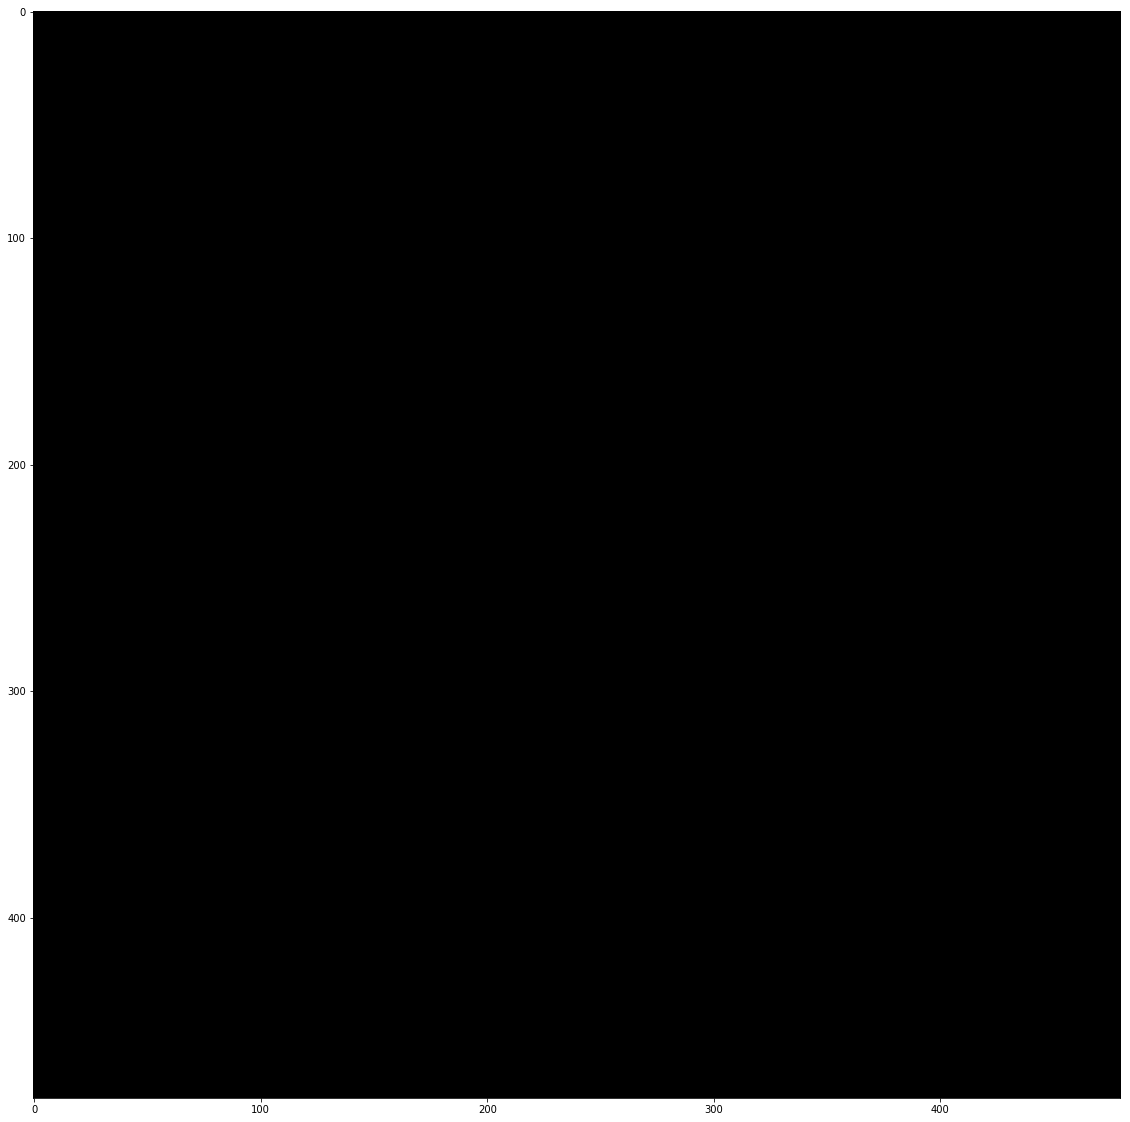

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import h5py

"""
loading vae model back is not a straight-forward task because of custom loss layer.
we have to define some architecture back again to specify custom loss layer and hence to load model back again.
"""


# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(3,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# load saved models
#vae = keras.models.load_model('cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
 #   custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
#encoder = keras.models.load_model('cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
 #   custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
#generator = keras.models.load_model('cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
 #   custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})




# display images generated from randomly sampled latent vector
n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, 3))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, 3)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [22]:
# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(3,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])


# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 16 * 16, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 16, 16)
else:
    output_shape = (batch_size, 16, 16, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(3,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])

# entire model
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 32, 32, 2)    0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 32, 32, 3)    27          input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 16, 16, 32)   416         conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_61[0][0]                  
__________________________________________________________________________________________________
conv2d_63 

/Users/admin/Documents/seeg/Seegnature/torch/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Output "custom_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_4" during training.


In [23]:

(x_train, _), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

# training
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator


ValueError: cannot reshape array of size 153600000 into shape (50000,32,32,2)

In [19]:
vae.save('cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
generator.save('cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs))

# save training history
fname = 'cifar10_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    cPickle.dump(history.history, file_pi)

NameError: name 'encoder' is not defined

/Users/admin/Documents/seeg/Seegnature/torch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


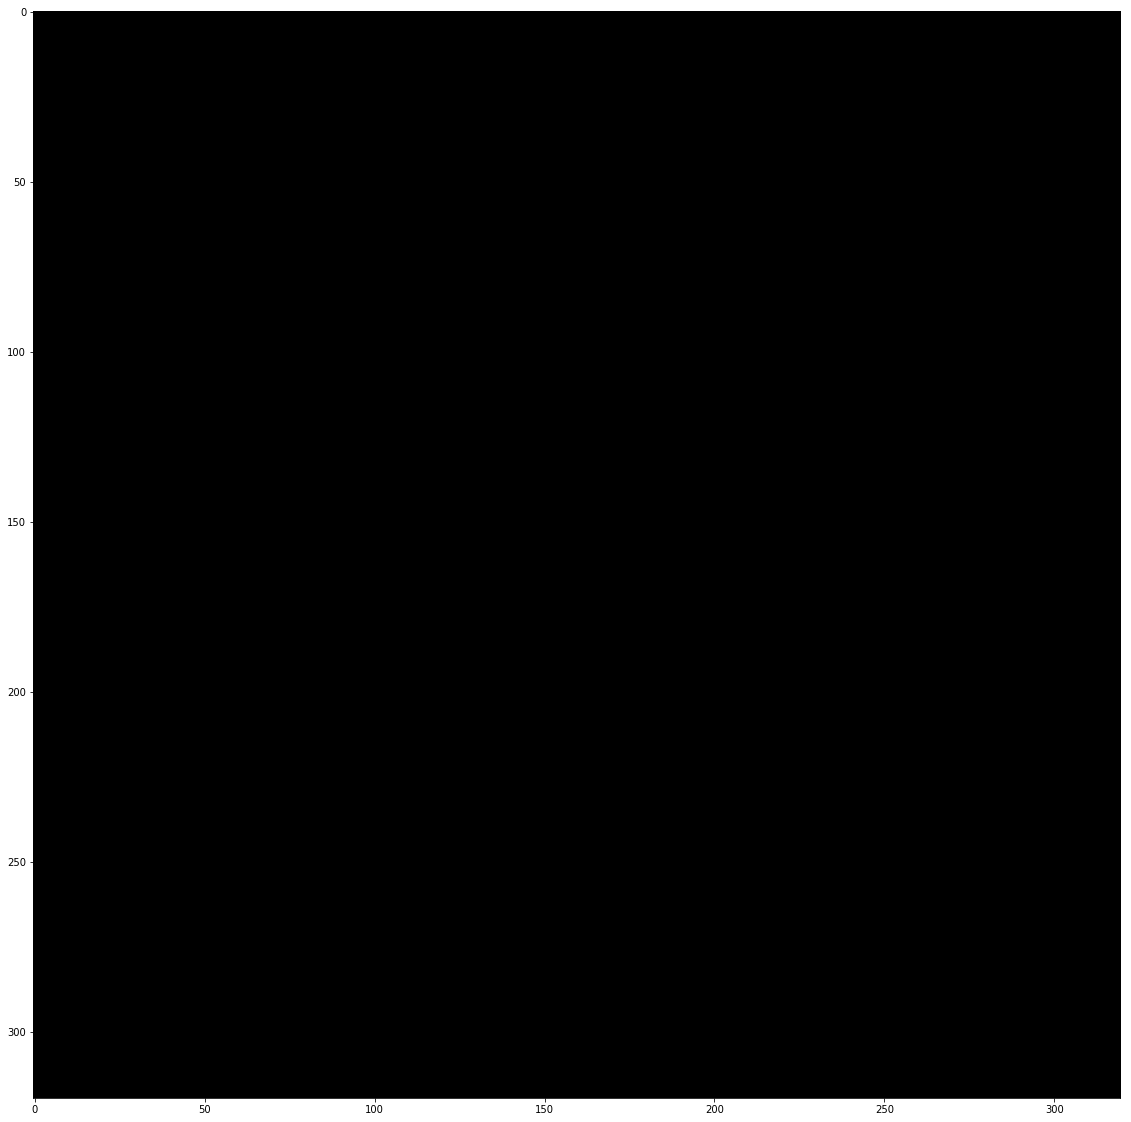

In [6]:

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(3,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# display a 2D manifold of the digits
n = 1  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_z = norm.ppf(np.linspace(0.05, 0.95, n))

#x_decoded = generator.predict([0.1,0.7,0.3], batch_size=3)
#digit = x_decoded[0].reshape(digit_size, digit_size,3)
#plt.imshow(digit,cmap='gray')
#plt.show()
#z_sample = np.array([[xi, yi, zi]])
#z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
#print("z_sample",z_sample)
#print("z_sample",z_sample.shape)

n = 10
img_size = 32
figure = np.zeros((img_size * n, img_size * n, 3))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()